# Na wstępie

Ukończyłem Wakacyjne Wyzwanie Solvro, ale jednocześnie brałem udział w kursie Machine Learning Specialization by Andrew Ng i chciałem się trochę pobawić / utrwalić swoje wiadomości z tego zakresu 


In [2]:
import os
import kaggle
import splitfolders 
import tensorflow as tf
import shutil
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, 
    Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint



### pobranie i posortowanie datasetu


In [3]:
SEED = 857191091 #dzwon smialo 
data_path = './data'
data_tmp = './data_tmp'

tensor = tf.constant([])
print(tensor.device)

tf.random.set_seed(SEED)
np.random.seed(SEED)
tf.config.experimental.enable_op_determinism()

if os.path.exists(data_path):
    print("Dane sa juz pobrane")
else:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('gergvincze/simple-hand-drawn-and-digitized-images', path=data_tmp, unzip=True)
    splitfolders.ratio(input=data_tmp, move=True, output=data_path, seed=SEED, ratio=(0.7, 0.15, 0.15))
    shutil.rmtree(data_tmp)

/job:localhost/replica:0/task:0/device:GPU:0
Dane sa juz pobrane


I0000 00:00:1761136018.644783   27450 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


analiza danych była już w zadanie.ipynb więc tutaj pominę ten etap 

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 130)

train_ds = image_dataset_from_directory(
    'data/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',  
    shuffle=True,
    seed=SEED
)

test_ds = image_dataset_from_directory(
    'data/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

val_ds = image_dataset_from_directory(
    'data/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

class_names = train_ds.class_names



Found 297 files belonging to 10 classes.


2025-10-22 14:26:59.491198: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:41] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykernel_launcher.runfiles/cuda_nvdisasm
  ipykernel_launcher.runfiles/nvidia_nvshmem
  ipykern/cuda_nvcc
  ipykern/cuda_nvdisasm
  ipykern/nvidia_nvshmem
  
  /usr/local/cuda
  /opt/cuda
  /home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/tensorflow/python/platform/../../cuda
  /home/fidok/

Found 74 files belonging to 10 classes.
Found 60 files belonging to 10 classes.


In [5]:
print(f"klasy: {train_ds.class_names}")
print(f"liczba klas: {len(train_ds.class_names)}")

klasy: ['anchor', 'balloon', 'bicycle', 'envelope', 'paper_boat', 'peace_symbol', 'smiley', 'speech_bubble', 'spiral', 'thumb']
liczba klas: 10


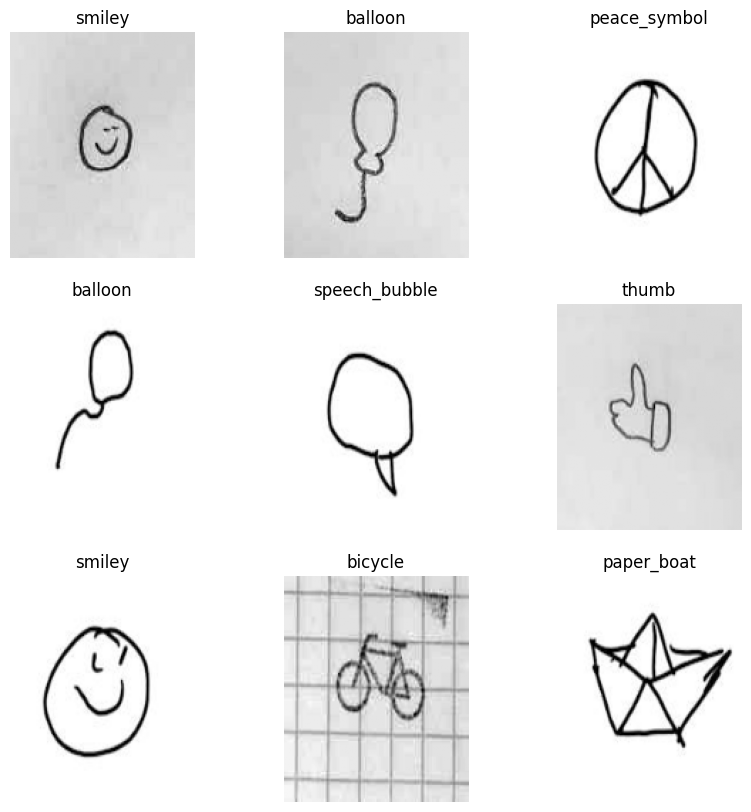

In [6]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(train_ds.class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
    break

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(9, 160, 130, 1)
(9, 10)


2025-10-22 14:27:01.543051: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-10-22 14:27:01.867416: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_5}}


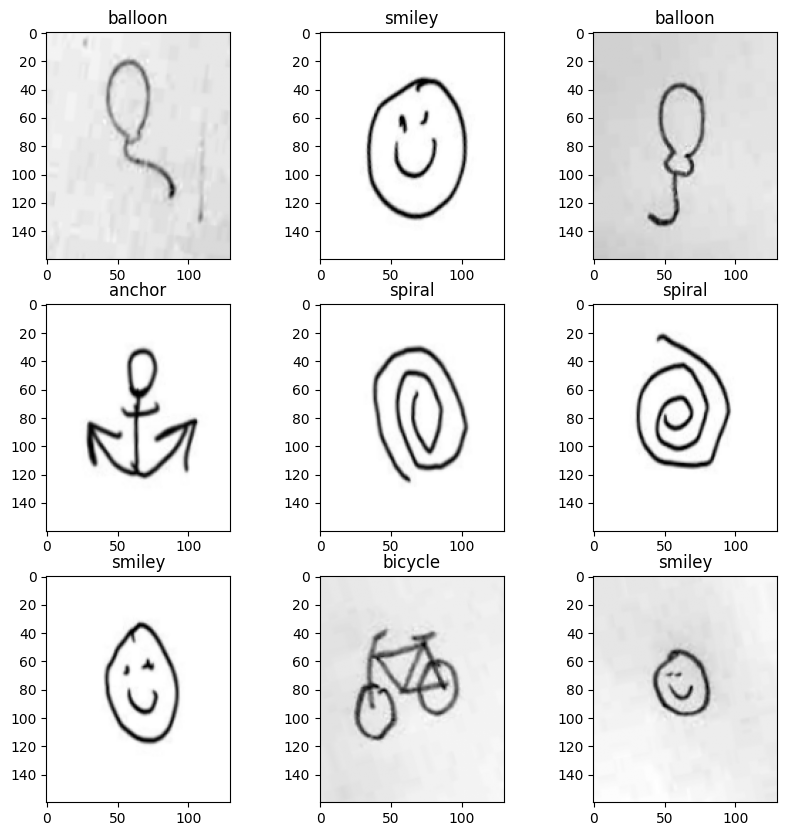

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#roatacja bo niektore obrazki byly krzywe i aby sie nie przyuczyl 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.1)
])

AUTOTUNE = tf.data.AUTOTUNE
#znormalizowanie danych grayscale do przedizalu [0,1]
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))
#zapamietanie danych w RAM
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.cache().prefetch(AUTOTUNE)


for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
    plt.show()
    break

In [9]:
model = Sequential([
    Input(shape=(160, 130, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(), 
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='linear')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,257,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353,034 (31.86 MB)

 Trainable params: 8,353,034 (31.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint(
    "model_najlepszy.keras",
    monitor="val_loss",    
    save_best_only=True,       
    mode="min",                
    verbose=1                  
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[checkpoint]
)

Epoch 1/40


2025-10-22 14:27:06.136155: W external/local_xla/xla/service/gpu/llvm_gpu_backend/nvptx_backend.cc:110] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2025-10-22 14:27:06.146181: W external/local_xla/xla/service/gpu/llvm_gpu_backend/nvptx_backend.cc:110] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2025-10-22 14:27:06.148737: W external/local_xla/xla/service/gpu/llvm_gpu_backend/nvptx_backend.cc:110] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2025-10-22 14:27:06.157849: W external/local_xla/xla/service/gpu/llvm_gpu_backend/nvptx_backend.cc:110] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2025-10-22 14:27:06.160622: W external/local_xla/xla/service/gpu/llvm_gpu_backend/nvptx_backend.cc:110] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
error: libdevice not found at ./libdevice.10.bc
2025-10-22 14:27:06.164806: W ex

UnknownError: Graph execution error:

Detected at node adam/Pow_7 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/home/fidok/.pyenv/versions/3.13.7/lib/python3.13/asyncio/base_events.py", line 683, in run_forever

  File "/home/fidok/.pyenv/versions/3.13.7/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once

  File "/home/fidok/.pyenv/versions/3.13.7/lib/python3.13/asyncio/events.py", line 89, in _run

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 701, in shell_main

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 379, in execute_request

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 899, in execute_request

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 471, in do_execute

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 632, in run_cell

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/tmp/ipykernel_27450/1142451396.py", line 13, in <module>

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 81, in train_step

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py", line 463, in apply_gradients

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py", line 527, in apply

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py", line 593, in _backend_apply_gradients

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/optimizer.py", line 120, in _backend_update_step

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/optimizer.py", line 134, in _distributed_tf_update_step

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/optimizer.py", line 131, in apply_grad_to_update_var

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/optimizers/adam.py", line 110, in update_step

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/ops/numpy.py", line 6587, in power

  File "/home/fidok/Projects/Solvro/ZadanieRekrutacyjne/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/numpy.py", line 2719, in power

JIT compilation failed.
	 [[{{node adam/Pow_7}}]] [Op:__inference_multi_step_on_iterator_2856]

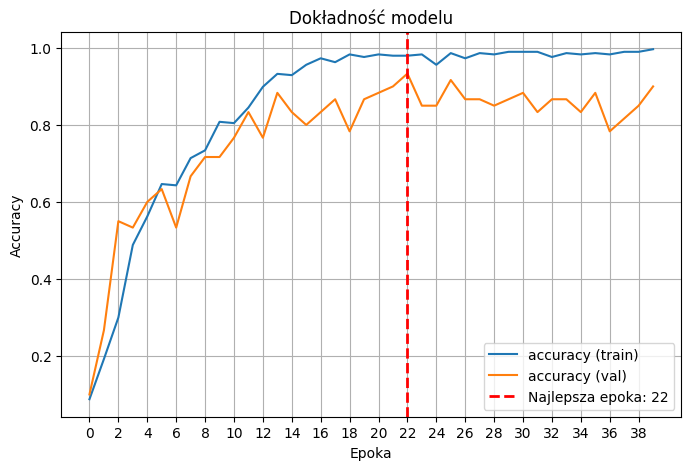

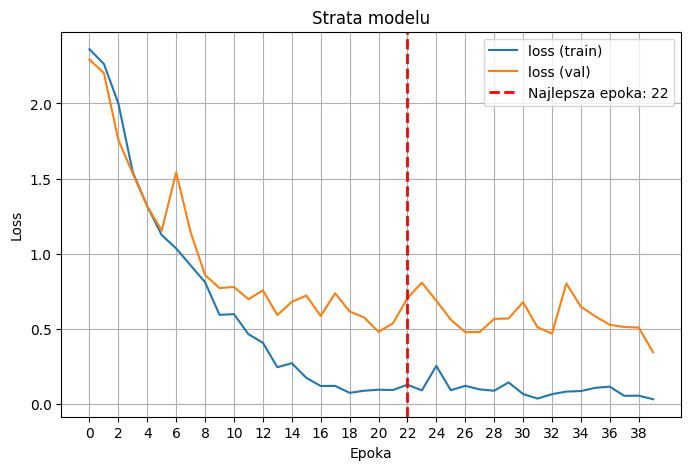

In [ ]:
best_epoch = np.argmax(history.history['val_accuracy'])

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='accuracy (train)')
plt.plot(history.history['val_accuracy'], label='accuracy (val)')
plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, label=f'Najlepsza epoka: {best_epoch}')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.xticks(range(0, len(history.history['accuracy']), 2)) 
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='loss (train)')
plt.plot(history.history['val_loss'], label='loss (val)')
plt.title('Strata modelu')
plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, label=f'Najlepsza epoka: {best_epoch}')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.xticks(range(0, len(history.history['loss']),2))  
plt.legend()
plt.grid(True)
plt.show()


I tak w sumie jako ze tf pozwala sledzic tylko 1 parametr to nie mozna byc w 100 % pewnym ze wybral najlepsze możliwe parametry dla naszego modelu 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025-10-17 19:18:24.665253: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


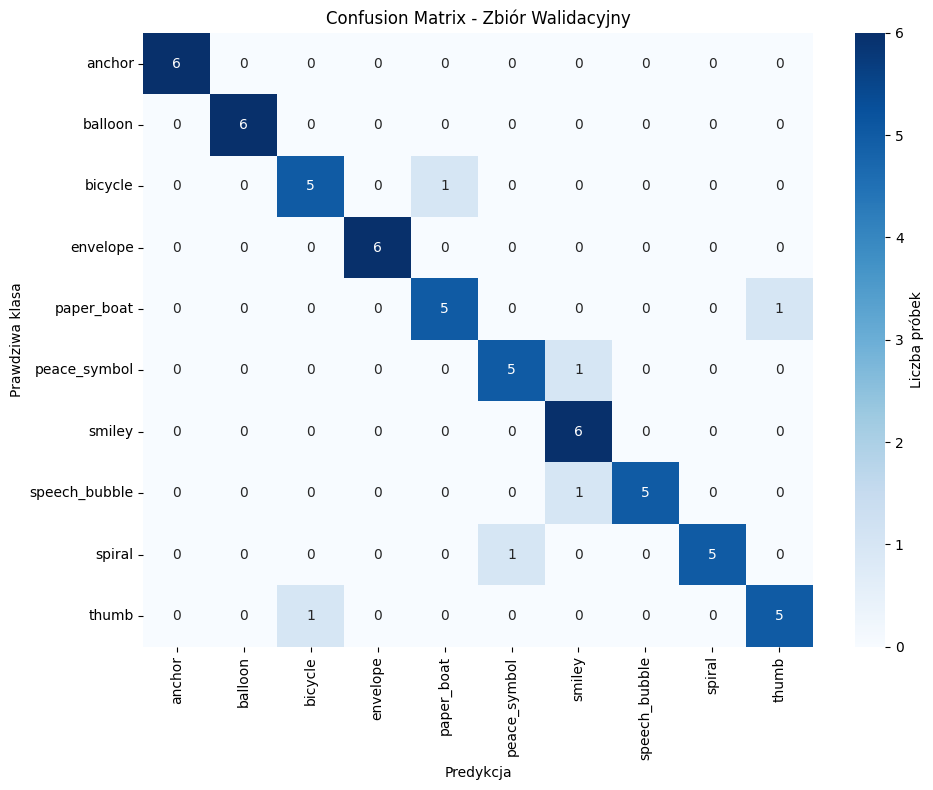


📊 Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00         6
      balloon       1.00      1.00      1.00         6
      bicycle       0.83      0.83      0.83         6
     envelope       1.00      1.00      1.00         6
   paper_boat       0.83      0.83      0.83         6
 peace_symbol       0.83      0.83      0.83         6
       smiley       0.75      1.00      0.86         6
speech_bubble       1.00      0.83      0.91         6
       spiral       1.00      0.83      0.91         6
        thumb       0.83      0.83      0.83         6

     accuracy                           0.90        60
    macro avg       0.91      0.90      0.90        60
 weighted avg       0.91      0.90      0.90        60



In [ ]:

y_val_pred_labels = np.argmax(model.predict(val_ds), axis=1)

# Pobierz prawdziwe etykiety
y_val_true = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in val_ds])

# Stwórz confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_val_pred_labels)

# Wyświetl heatmapę
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, 
           yticklabels=class_names,
           cbar_kws={'label': 'Liczba próbek'})
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa klasa')
plt.title('Confusion Matrix - Zbiór Walidacyjny')
plt.tight_layout()
plt.show()

# Statystyki
from sklearn.metrics import classification_report
print("\n📊 Raport klasyfikacji:")
print(classification_report(y_val_true, y_val_pred_labels, target_names=class_names))
# ...existing code...